# Function Approximation


Sciences Po, Spring 2021


## Outline

1. Overview of Approximation Methods
	1. Interpolation
	1. Regression
1. Polynomial Interpolation
1. Spline Interpolation
1. Multidimensional Approximation




## Approximation Methods

* Confronted with a non-analytic function $f$ (i.e. something not like $log(x)$), we need a way to numerically represent $f$ in a computer.
	* If your problem is to compute a value function in a dynamic problem, you don't have an *analytic representation* of $V$.
	* If you need to compute an equilibrium distribution for your model, you probably can't tell it's from one parametric family or another. Hence you need to approximate it.


* Approximations use *data* of some kind which informs us about $f$. Most commonly, we know the function values $f(x_i)$ at a corresponding finite set of points $X = \{x_i\}_{i=1}^N$.
* The task of approximation is to take that data and tell us what the function value is at $f(y),y\not \in X$.
* To an economist this should sound very familiar: take a dataset, learn it's structure, and make predictions.
* The only difference is that we can do much better here, because we have more degree's of freedom (we can choose our $X$ in $Y=\beta X + \epsilon$)


## Some Taxonomy

* Local Approximations: approximate function and it's derivative $f,f'$ at a *single* point $x_0$. Taylor Series:
	$$ f(x) = f(x_0) + (x-x_0)f'(x_0) + \frac{(x-x_0)^2}{2}f''(x_0) + \dots + \frac{(x-x_0)^n}{n!}f^{n}(x_0) $$
* Interpolation or *Colocation*: find a function $\hat{f}$ that is a good fit to $f$, and require that $\hat{f}$ *passes through* the points. If we think of there being a *residual* $\epsilon_i = f(x_i) - \hat{f}(x_i)$ at each grid point $i$, this methods succeeds in setting $\epsilon_i=0,\forall i$.
* Regression: Minimize some notion of distance (or squared distance) between $\hat{f}$ and $f$, without the requirement of pass through. 

## Doing Interpolation in Julia

* In practice, you will make heavy use of high-quality interpolation packages in julia.
* List in the end.
* Nevertheless, function approximation is *extremely* problem-specific, so sometimes a certain approach does not work for your problem.
* This is why we will go through the mechanics of some common methods.
* I would like you to know where to start drilling if you need to go and hack somebody elses code.

## Basis Functions

1. What is a basis?
2. What is a basis function?

### *Basis* in Linear Algebra

* We call a basis $B$ of a vector space $V$ over a field $F$ (such as the real numbers $\mathbb{R}$) a *linearly independent subset* of $V$ that *spans* $V$.
* In other words $B \subset V$ is called a *basis* if it satisfies
    1. linear independence: for all subsets $b_1,b_2,\dots,b_n$, and for all scalars $a_1,a_2,\dots,a_n\in F$, we have that if $b_1 a_1 + b_2 a_2 +\dots+b_n a_n = 0$, then $a_1 = a_2 =\dots= a_n = 0$
    1. spanning of $V$: for all vectors $\mathbf{v} \in V$, one can choose $b_1,b_2,\dots,b_n \in B$ and $v_1,v_2,\dots,v_n \in V$ s.t. $\mathbf{v} = b_1 v_1 + b_2 v_2 +\dots+b_n v_n$
* From those definitions you can see that the $b$ are like *weights*, and that one can represent vectors are *linear combinations* of other vectors.

### Basis Example in R2

* The set $\mathbb{R}^2$ of ordered pairs of real numbers is a vector space $V$ for
    1. component-wise addition: $(a,b) + (c,d) = (a+c, b+d)$
    2. scalar multiplication: $\lambda (a,b) = (\lambda a, \lambda b), \lambda \in \mathbb{R}$.
* One basis called the *standard basis* of $V$ consists of two vectors:
    1. $e_1 = (1,0)$
    2. $e_2 = (0,1)$
* Any vector $v=(a,b) \in \mathbb{R}^2$ can be uniquely written as $v = ae_1 + be_2$
* Any other pair of linearly independent vectors like $(1,1)$ and $(-1,2)$ is also a basis of $\mathbb{R}^2$.

### Higher Dimensions

* If the field $F$ has more than 2 dimensions, $n$ say, we work with $n$-tuples.
* For example, $e_i = (0,\dots,0,1,0\dots,0)$ with the $i$th component $1$.
* The set of all *monomials* forms a particular basis: the *monomial basis*: ${1,X,X^2,X^3,\dots}$
* **Any** set of polynomials with a unique polynomial for each degree is also a basis, called a *polynomial sequence*. A prominent example here are the *Chebyshev polynomials*, which we will encounter again.


## What is a Basis *function*?

* Now we know that every vector $\mathbf{v}$ in a vector space $V$ can be represented by a linear combination of *basis vectors*.
* Similarly, we can represent every *continuous* function in a particular *function space* $F$ by a linear combination of *basis functions*.
* Another good name for basis functions is *blending functions*. We often use a mixture of several basis functions to find an approximation.

## Approximating Functions

* Let $F$ by the space of continuous real-valued functions with domain $\mathbf{x}\in \mathbb{R}$. $F$ is a vector space.
* Next, we define an inner-product operation on that space:
    $$
    <g,h> = \int_\mathbf{x} g(x) h(x) w(x) dx
    $$
    where functions $g,h,w \in F$ and $w$ is a weighting function.
* the pair $\{F, <.,.>\}$ form an *inner-product vector space*.
* Now we want to approximate a **known** function $f:\mathbf{x}\mapsto\mathbb{R}$ in $\{F, <.,.>\}$


* Let's define $\hat{f}(\cdot;c)$ to be our parametric approximation function. We generically define this as

$$  
    \hat{f}(x;c) = \sum_{j=0}^{J-1} c_j \phi_j(x) 
$$

where 
* $\phi_j : \mathbb{R}^d \mapsto \mathbb{R}$ is called a **basis function**, and $\Phi_J = \{\phi_j\}_{j=0}^{J-1}$.
* $c={c_0,c_1,\dots,c_{J-1}}$ is a coefficient vector
* The integer $J$ is the *order* of the interpolation.
* Our problem is to choose $(\phi_i,c)$ in some way.
* We want to minimize the residual function, i.e. $\gamma(x,c) \equiv f(x) - \sum_{j=0}^{J-1} c_j \phi_j(x)$

* To find coefficients $c$, one could for example minimize the squared errors, OLS:
    $$
    c^* = \arg \min \int_\mathbf{x} \gamma(x,c) w(x) dx
    $$
* In standard OLS, we'd set the weighting function to $w(x) = 1$

We will construct a *grid* of $M\geq J$ points ${x_1,\dots,x_M}$ within the domain $\mathbb{R}^d$, and we will denote the *residuals* at each grid point by $\epsilon = {\epsilon_1,\dots,\epsilon_M}$:	

$$ 
    \left[\begin{array}{c}
        \epsilon_1 \\
         \vdots \\
        \epsilon_M \\ \end{array} \right]  = \left[\begin{array}{c} f(x_1) \\ \vdots \\ f(x_M)  \end{array} \right] - \left[\begin{array}{ccc} 
        \phi_1(x_1) & \dots & \phi_J(x_1) \\   
        \vdots      & \ddots & \vdots \\   
        \phi_1(x_M) & \dots & \phi_J(x_M)    
        \end{array} \right]  \cdot 
        \left[\begin{array}{c} c_1 \\ \vdots \\ c_J  \end{array} \right] \\
        \mathbf{\epsilon} = \mathbf{y} - \mathbf{\Phi c}
$$

* *Interpolation* or *colocation* occurs when $J=M$, i.e. we have a square matrix of basis functions, and can exactly solve this.
* We basically need to solve the system

$$ 
\begin{aligned} 
\sum_{j=1}^n c_j \phi_j(x_i) &= f(x_i),\forall i=1,2,\dots,n \\
                  \mathbf{\Phi c}&= \mathbf{y}
\end{aligned}
$$

where the second line uses vector notation, and $\mathbf{y}$ has all values of $f$.
* Solution: $\mathbf{c}= \mathbf{\Phi}^{-1}y$.




## Regression Basics

* If we have more evaluation points than basis functions, $M>J$ say, interpolation nodes than basis functions, we cannot do that. Instead we can define a loss function, and minimize it. 
* In the case of squared loss, of course, this leads to the least squares solution:

$$ 
\begin{aligned} e_i &= f(x_i) - \sum_{j=1}^n c_j \phi_j(x_i) \\
        \min_c e_i^2 & \implies \\
        c            &= (\Phi'\Phi)^{-1} \Phi'y
\end{aligned}
 $$


## Spectral and Finite Element Methods

* **Spectral Methods** are such that the basis functions are non-zero over the entire domain of $f$.
	* Polynomial interpolation
	* Chebychev interpolation
* **Finite Element** methods are such that basis functions are non-zero only on a subset of the domain.
	* Splines
		* Linear splines, i.e. splines of degree 1, a.k.a. *linear approximation*
		* Higher order splines, mainly the *cubic spline*.


## What makes a **good** Approximation?

* Should be arbitrarily accurate as we increase $n$.
* $\Phi$ Should be efficiently (fast) computable. If $\Phi$ were differentiable, we could easily get e.g. $\hat{f}'(x) = \sum_{j=1}^J c_j \phi_j'(x_i)$
* $c$ Should be efficiently (fast) computable.




## What Polynomial to use? What form for $\Phi$?

* In principle the *monomial basis* could be used. It is just the power functions of $x$: $1,x,x^2,x^3,\dots$
* Stacking this up for each evaluation node gives the *Vandermonde Matrix*:
  
$$ 
V = \left[\begin{matrix} 
        1 & x_1 & \dots & x_1^{n-2} & x_1^{n-1} \\ 
        1 & x_2 & \dots & x_2^{n-2} & x_2^{n-1} \\ 
        \vdots & \vdots & \ddots &  & \vdots \\ 
        1 & x_m & \dots & x_m^{n-2} & x_m^{n-1} 
        \end{matrix} \right]
$$


for the case with $m$ evaluation nodes for $x$, and $n$ basis functions for each $x_i$.




### Choosing Basis Matrices

* If we choose $\Phi$ so that it's elements share a lot of information, it will be hard to invert it.
* So, if the elements share very little information, it's easier to invert, hence good for us
* For example, if we have $\Phi$ close to diagonal (i.e. different basis $\phi_j(x)$ are non-zero at different $x$).
* Such $\Phi$ are generated by using *orthogonal Polynomials* (under our inner product definition).
* An orthogonal Polynomial has 2 sequences of polynomials orthogonal under an inner product: their inner product is zero under a certain weighting function $w(x)$. 


### Choosing Basis Matrices

* For example, the Chebyshev polynomials are orthogonal wrt. to weight $\frac{1}{\sqrt{1-x^2}}$
* for degrees $n,m$ of that polynomial, $T_n,T_m$, we have
    $$
    \int_{-1}^1 T_n(x)T_m(x)\,\frac{dx}{\sqrt{1-x^2}}=
    \begin{cases}
        0 & n\ne m \\ \pi & n=m=0 \\ \frac{\pi}{2} & n=m\ne 0
    \end{cases}
    $$

### Chebyshev Polynomials *of the first kind*

* There is a nice recursion to get $T_n(x)$:
    \begin{align}
        T_0(x) & = 1 \\
        T_1(x) & = x \\
        T_{n+1}(x) & = 2xT_n(x) - T_{n-1}(x).
    \end{align}
* Code that up and compute $T_{3}(0.5)$!
* Check you get the same as with the alternative closed form $T_n(x) = \cos(n \arccos(x))$

In [1]:
function T(x,n)
    @assert (x >= -1) & (x <= 1)
    if n == 0
        return 1.0
    elseif n==1
        return x
    else
        2*x*T(x,n-1) - T(x,n-2)
    end
end
T2(x,n) = cos(n* acos(x))
@show T(0.5,3)
using Test
@assert T2(0.5,3) == T(0.5,3)        

T(0.5, 3) = -1.0


In [2]:
# weighting function
w(x) = 1.0 / sqrt(1-x^2)
using Statistics
using Test

# simple integration works for n not equal m
@assert isapprox(mean(T(x,0) * T(x,1) * w(x) for x in range(-0.99,stop = 0.99, length=100)), 0.0, atol = 1e-16)
@assert isapprox(mean(T(x,4) * T(x,5) * w(x) for x in range(-0.99,stop = 0.99, length=100)), 0.0, atol = 1e-16)


## Chebyshev Nodes

* *Chebyshev Nodes* are the roots of the chebyshev polynomial (i.e. where $P(x) = 0$).
* They are defined in the interval $[-1,1]$ as 
    $$ x_i = \cos\left(\frac{2k-1}{2n} \pi\right), k=1,\dots,n $$
* Which maps to general interval $[a,b]$ as
	$$ x_i = \frac{1}{2} (a+b) + \frac{1}{2} (b-a) \cos\left(\frac{2k-1}{2n} \pi\right) , k=1,\dots,n $$
* Chebyshev nodes are **not** evenly spaced: there are more points towards the boundaries. You might remember that from Gaussian Integration nodes.

In [3]:
using Plots
using FastGaussQuadrature
gcnodes = gausschebyshev(21)  # generate 11 Chebyshev Nodes
gr()
scatter(gcnodes,ones(21),ylims=(0.9,1.1),m=(:red,:+),legend=false,size=(600,100),yticks=nothing)

LoadError: ArgumentError: Package FastGaussQuadrature not found in current path:
- Run `import Pkg; Pkg.add("FastGaussQuadrature")` to install the FastGaussQuadrature package.


### Constructing $\Phi$ as $T$ evaluated *at* the Chebyshev Nodes
* Combining Chebyshev nodes evaluated at the roots $T$ of the Cheby polynomial to construct $\Phi$ is a particularly good idea.
* Doing so, we obtain an interpolation matrix $\Phi$ with typical element
	$$ \phi_{ij} = \cos\left( \frac{(n-i+0.5)(j-1)\pi}{n}\right)  $$
* And we obtain that $\Phi$ is indeed orthogonal
	$$ \Phi^T \Phi = \text{diag}\{n,n/2,n/2,\dots,n/2\}  $$




In [4]:
using BasisMatrices
x = range(-4, stop = 4 ,length = 10)
ϕ = Basis(ChebParams(length(x),-4,4))
ϕ

LoadError: ArgumentError: Package BasisMatrices not found in current path:
- Run `import Pkg; Pkg.add("BasisMatrices")` to install the BasisMatrices package.


In [5]:
S, y = nodes(ϕ)

LoadError: UndefVarError: nodes not defined

In [6]:
Φ = BasisMatrix(ϕ, Expanded(), S, 0)

LoadError: UndefVarError: Expanded not defined

In [7]:
Φ.vals[1]' * Φ.vals[1]

LoadError: UndefVarError: Φ not defined

## (Chebyshev) Interpolation Proceedure

* Let's summarize this proceedure.
* Instead of Chebyshev polynomials we could be using any other suitable family of polynomials.
* To obtain a Polynomial interpolant $\hat{f}$, we need:
	1. a function to $f$ interpolate. We need to be able to get the function values somehow.
	1. A set of (Chebyshev) interpolation nodes at which to compute $f$
	1. An interpolation matrix $\Phi$ that corresponds to the nodes we have chosen.
	1. A resulting coefficient vector $c$
* To obtain the value of the interpolation at $x'$ off our grid, we also need a way to evaluate $\Phi(x')$.
	1. Evaluate the Basis function $\Phi$ at $x'$: get $\Phi(x')$
	2. obtain new values as $y = \Phi(x') c$.

## Polynomial Interpolation with `Julia`: `ApproxFun.jl`

* [`ApproxFun.jl`](https://github.com/ApproxFun/ApproxFun.jl) is a Julia package based on the Matlab package [`chebfun`](http://www.chebfun.org). It is quite amazing.
* More than just *function approximation*. This is a toolbox to actually *work* with functions.
* given 2 functions $f,g$, we can do algebra with them, i.e. $h(x) = f(x) + g(x)^2$
* We can differentiate and integrate
* Solve ODE's and PDE's
* represent periodic functions
* Head over to the [website and look at the readme](https://github.com/JuliaApproximation/ApproxFun.jl).

In [8]:
using LinearAlgebra, SpecialFunctions, Plots, ApproxFun
x = Fun(identity,0..10)
f = sin(x^2)
g = cos(x)

h = f + g^2
r = roots(h)
rp = roots(h')

using Plots
plot(h,labels = "h")
scatter!(r,h.(r),labels="roots h")
scatter!(rp,h.(rp),labels = "roots h'")

LoadError: ArgumentError: Package SpecialFunctions not found in current path:
- Run `import Pkg; Pkg.add("SpecialFunctions")` to install the SpecialFunctions package.


In [9]:
# works even with discontinuities!
ff = x->sign(x-0.1)/2 + cos(4*x);  # sign introduces a jump at 0.1
x  = Fun(identity)	# set up a function space
space(x)
f  = ff(x)	# define ff on that space
plot(f)	# plot

LoadError: UndefVarError: Fun not defined

In [10]:
# whats the first deriv of that function at at 0.785?
println(f'(0.785))
# and close to the jump, at 0.100001?
println(f'(0.1000001))
# integral of f?
g1 = cumsum(f)
g = g1 + f(-1)
integral = norm(f-g)
integral

LoadError: UndefVarError: f not defined


* The main purpose of this package is to manipulate analytic functions, i.e. function with an algebraic representation.
* There is the possibility to supply a set of data points and fit a polynomial:

In [11]:
S = Chebyshev(1..2);
n = 100; m = 50;
p = range(1,stop=2,length=n);   # a non-default grid
v = exp.(p);           # values at the non-default grid
V = Array{Float64}(undef,n,m); # Create a Vandermonde matrix by evaluating the basis at the grid
for k = 1:m
    V[:,k] = Fun(S,[zeros(k-1);1]).(p)
end
f = Fun(S,V\v);
@show f(1.1)
@show exp(1.1)


LoadError: UndefVarError: .. not defined

## Splines: Piecewise Polynomial Approximation

* Splines are a finite element method, i.e. there are regions of the function domain where some basis functions are zero.
* As such, they provide a very flexible framework for approximation instead of high-order polynomials.
	* Keep in mind that Polynomials basis functions are non-zero on the entire domain. Remember the Vandermonde matrix.
* They bring some element of local approximation back into our framework. What happens at one end of the domain to the function is not important to what happens at the other end.
* Looking back at the previous plot of random data: we are searching for **one** polynomial to fit **all** those wiggles. A spline will allow us to design **different** polynomials in different parts of the domain.


### Splines: Basic Setup

* The fundamental building block is the *knot vector*, or the *breakpoints vector* $\mathbf{z}$ of length $p$. An element of $\mathbf{z}$ is $z_i$.
* $\mathbf{z}$ is ordered in ascending order.
* $\mathbf{z}$ spans the domain $[a,b]$ of our function, and we have that $a=z_1,b=z_p$
* A spline is of *order k* if the polynomial segments are k-th order polynomials.
* Literature: [@deboor] <cite data-cite=deboo></cite> is the definitive reference for splines.

### Splines: Characterization

* Given $p$ knots, there are $p-1$ polynomial segments of order $k$, each characterized by $k+1$ coefficients, i.e. a total of $(p-1)(k+1)$ parameters.
* However, we also require the spline to be continuous and differentiable of degree $k-1$ at the $p-2$ interior breakpoints.
* Imposing that uses up an additional $k(p-2)$ conditions.
* We are left with $n = (p-1)(k+1) - k(p-2) = p+k-1$ free parameters.
* A Spline of order $k$ and $p$ knots can thus be written as a linear combination of it's $n = p+k-1$ basis functions.


## B-Splines: Definition

* We mostly use Basis Splines, or **B-Splines**.
* Here is a recursive definition of a B-Spline (and what is used in `ApproXD`):
* Denote the $j$-th basis function of degree $k$ with knot vector $\mathbf{z}$  at $x$ as $B_j^{k,\mathbf{z}} (x)$
* Again, there are $n = k + p - 1$ $B$'s (where $p$` = length(z)`)
* We can define $B_j^{k,\mathbf{z}} (x)$ recursively like this:

	$$ 
    B_j^{k,\mathbf{z}} (x) = \frac{x-z_{j-k}}{z_j - z_{j-k}} B_{j-1}^{k-1,\mathbf{z}} (x)  + \frac{z_{j+1}-x}{z_{j+1} - z_{j+1-k}} B_{j}^{k-1,\mathbf{z}} (x), j=1,\dots,n
    $$

* The recursion starts with

$$ B_j^{0,\mathbf{z}} (x) = \begin{cases}
    1 & \text{if }z_j \leq x <	z_{j+1}\\
    0 & \text{otherwise.}
    \end{cases}
$$

* For this formulation to work, we need to extend the knot vector for $j<1,j>p$:
	
$$ z_j = \begin{cases}
    a & \text{if }j \leq 1\\
    b & \text{if }j \geq p
    \end{cases} 
$$
        
* And we need to set the endpoints
	$$ B_0^{k-1,\mathbf{z}} = B_n^{k-1,\mathbf{z}} =0 $$
* You may see that this gives rise to a triangular computation strategy, as pointed out [here](http://www.cs.mtu.edu/~shene/COURSES/cs3621/NOTES/spline/B-spline/bspline-basis.html).



## B-Splines: Derivatives and Integrals

* This is another very nice thing about B-Splines.
* The derivative wrt to it's argument $x$ is

	$$ \frac{d B_j^{k,\mathbf{z}} (x)}{dx} = \frac{k}{z_j - z_{j-k}} B_{j-1}^{k-1,\mathbf{z}} (x)  + \frac{k}{z_{j+1} - z_{j+1-k}} B_{j}^{k-1,\mathbf{z}} (x), j=1,\dots,n
    $$
    
* Similarly, the Integral is just the sum over the basis functions:
	$$ \int_a^x B_j^{k,\mathbf{z}} (y) dy = \sum_{i=j}^n \frac{z_i - z_{i-k}}{k} B_{i+1}^{k+1,\mathbf{z}} (x)  $$



In [12]:
using ApproXD   
# ] dev https://github.com/floswald/ApproXD.jl
bs = BSpline(7,3,0,1) #7 knots, degree 3 in [0,1]
# how many basis functions? (go back 1 slide.)
# getNumCoefs(bs)
x = range(0,stop =1.0, length = 500)
B = Array(getBasis(collect(x),bs))
plot(x,B,layout=(3,3),grid=false,ylim=(-0.1,1.1),legend=false,linewidth=2,linecolor=:black)

LoadError: ArgumentError: Package ApproXD not found in current path:
- Run `import Pkg; Pkg.add("ApproXD")` to install the ApproXD package.


In [13]:
# Notice that placing each of those panels on top of each other generates a sparse matrix!
plot(x,B,grid=false,ylim=(-0.1,1.1),legend=false)

LoadError: UndefVarError: x not defined

## Linear B-Spline: A useful special case

* This is *connecting the dots with a straight line*
* This may incur some approximation error if the underlying function is very curved between the dots.
* However, it has some benefits: 
	* it is shape-preserving, 
	* it is fast,
	* it is easy to build.
* For a linear spline with evenly spaced breakpoints, this becomes almost trivial.
	* Let's define $h = \frac{b-a}{n-1}$ as the distance between breakpoints.
	* Our basis function becomes very simple, giving us a measure of how far $x$ is from the next knot:
    
$$ \phi_j (x) = \begin{cases}
    1 - \frac{|x-z_j|}{h} & \text{if } |x-z_j| \leq h \\
    0                    & \text{otherwise}
    \end{cases} 
$$

* Notice that each interior basis function (i.e. not 0 and not $n$) has witdth $2h$.

In [14]:
bs = BSpline(9,1,0,1) #9 knots, degree 1 in [0,1]
x = range(0,stop = 1.0,length = 500)
B = Array(getBasis(collect(x),bs))
plot(x,B,layout=(3,3),grid=false,ylim=(-0.1,1.1),legend=false,linewidth=2,linecolor=:black)

LoadError: UndefVarError: BSpline not defined

## Linear B-Spline: Evaluation

* In order to evaluate the linear interpolator, we need to know only one thing: Which knot span is active, i.e. what is $j$ s.t. $x\in [z_j, z_{j+1}]$?
* This is a classic problem in computer science. Binary search.
* `julia` implements [`searchsortedlast`](http://docs.julialang.org/en/release-0.4/stdlib/sort/#Base.searchsortedlast).	
* Once we know $j$, it's easy to get the interpolated value as
	$$ \hat{f}(x) = \frac{x-z_j}{h}  f(z_{j+1}) + \frac{z_{j+1}-x}{h}  f(z_{j}) $$




## The Importance of Knot Placement

* We just talked about *equally spaced knots*. This is just a special case.
* B-Splines give us the flexibility to place the knots where we want.
* Contrary to Polynomial interpolations (where we cannot choose the evaluation nodes), this is very helpful in cases where we know that a function is very curved in a particular region.
* Canonical Example: Runge's function: $f(x) = (1+25x^2)^{-1}$.
* Also: If you know that your function has a kink (i.e. a discontinuous first derivative) at $\hat{x}$, then you can stack breakpoints on top of each other *at* $\hat{x}$
* That's going to be part of your homework!

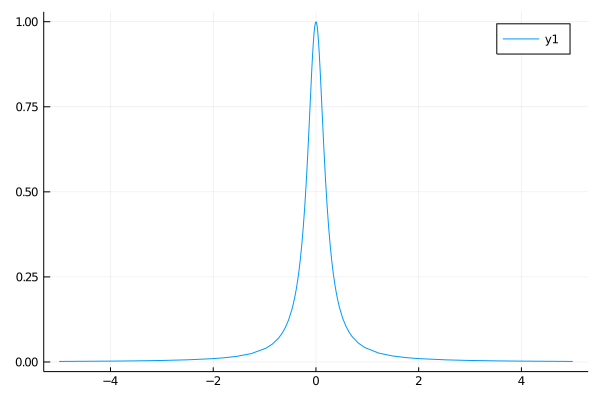

In [15]:
gg(x) = (1+25x^2)^(-1)
plot(gg)

## Interpolation with [`Interpolations.jl`](https://github.com/JuliaMath/Interpolations.jl)

* Interpolations.jl assumes that data is uniformly spaced on grid `1:N`
* Same for multiple dimensions
* However, we can scale `1:N` to different domains
* finally, we can also supply our own, non-uniform grids.
* Can get gradients of interpolations right away.

In [16]:
# interpolation
# restart kernel!
using Interpolations
A = rand(10,5)
itp = interpolate(A, Interpolations.BSpline(Quadratic(Reflect(OnCell()))))
itp(1.9,4.9)

LoadError: ArgumentError: Package Interpolations not found in current path:
- Run `import Pkg; Pkg.add("Interpolations")` to install the Interpolations package.


In [17]:
A


LoadError: UndefVarError: A not defined

In [18]:
A[2,5]

LoadError: UndefVarError: A not defined

In [19]:
A_x = 1.:2.:40.   # x in [1,40]
A = [log(x) for x in A_x] # f(x)
itp = interpolate(A, Interpolations.BSpline(Cubic(Interpolations.Line(OnGrid()))))
sitp = scale(itp, A_x)  # scale x-axis of interpolator
@show sitp(3.) # exactly log(3.)
@show sitp(3.5) # approximately log(3.5)
@show itp(3);  # is the 3rd index(!) in A, not the *value* 3

LoadError: UndefVarError: Interpolations not defined

In [20]:
# Same for 2D
A_x1 = 1:.1:10
A_x2 = 1:.5:20
fff(x1, x2) = log(x1+x2)
A = [fff(x1,x2) for x1 in A_x1, x2 in A_x2]
itp = interpolate(A, Interpolations.BSpline(Cubic(Interpolations.Line(OnGrid()))))
sitp = scale(itp, A_x1, A_x2)
sitp(5., 10.) # exactly log(5 + 10)
sitp(5.6, 7.1) # approximately log(5.6 + 7.1)

LoadError: UndefVarError: Interpolations not defined

* Very often we need a **gridded** interpolation. I.e. we supply the function values on an irregular grid.
* For this occasion, the `GriddedInterpolation` type is useful.
* For now this only works in 3 modes: 
    * Gridded(Linear())
    * Gridded(Constant())  nearest neighbor
    * NoInterp (you must supply index ON grid)

In [21]:
A = rand(20)
A_x = collect(1.0:2.0:40.0)
knots = (A_x,)
itp = interpolate(knots, A, Gridded(Linear()))
itp(2.0)

LoadError: UndefVarError: Linear not defined

In [22]:
# 2D
A = rand(8,20)
knots = ([x^2 for x = 1:8], [0.2y for y = 1:20])
itp = interpolate(knots, A, Gridded(Linear()))
itp(4,1.2)  # approximately A[2,6]

LoadError: UndefVarError: Linear not defined

In [23]:
# we can mix modes across dimensions!
itp = interpolate(knots, A, (Gridded(Linear()),Gridded(Constant())))
itp(4,1.2)

LoadError: UndefVarError: Linear not defined

* What about vector valued interpolations?
* Suppose we have a function $f : \mathbb{R} \mapsto \mathbb{R}^2$
* Economics example:

$$  
f(x) = \left(\begin{array}{c} \text{savings}(x) \\ \text{consumption}(x) \end{array} \right)
$$

* $x$ is cash on hand. 
* We often have situations where several functions are defined on a common support $x$.
* what is $f(1.75)$?

In [24]:
using StaticArrays
x = range(1,stop = 3, length = 200)  # cash on hand
a = Float64[log(1+j)*i for j in x, i in 1:2]   # cons and save function
b = reinterpret(SVector{2,Float64}, a')[:]
itp = interpolate(b, Interpolations.BSpline(Quadratic(Reflect(OnCell()))))
@show itp(3)
sitp = scale(itp,x)
@show sitp(3);

LoadError: ArgumentError: Package StaticArrays not found in current path:
- Run `import Pkg; Pkg.add("StaticArrays")` to install the StaticArrays package.


In [25]:
v = sitp(1.75)  # get interpolated values for both function
plot(x,a,labels=["save","cons"],yticks=convert(Array{Float64},v),xlabel="current cash")
vline!([1.75],lab="")
hline!([v[1],v[2]],lab="")

LoadError: UndefVarError: sitp not defined


## The CompEcon Toolbox of Miranda and Fackler

* another good alternative:
* [CompEcon.jl](https://github.com/spencerlyon2/CompEcon.jl)



## Multidimensional Approximation

* Up to now, most of what we did was in one dimesion.
* Economic problems *often* have more dimension than that.
	* The number of state variables in your value functions are the number of dimensions.
* We can readily extend what we learned into more dimensions.
* However, we will quickly run into feasibility problems: hello *curse of dimensionality*.



## Tensor Product of univariate Basis Functions: Product Rule

* One possibility is to approximate e.g. the 2D function $f(x,y)$ by
	$$ \hat{f}(x,y) = \sum_{i=1}^n \sum_{j=1}^m c_{i,j} \phi_i^x(x) \phi_j^y(y)  $$
	* here $\phi_i^x$ is the basis function in $x$ space, 
	* you can see that the coefficient vector $c_{i,j}$ is indexed in two dimensions now.
	* Notice that our initial notation was general enough to encompass this case, as we defined the basis functions as $\mathbb{R}^d \mapsto \mathbb{R}$. So with the product rule, this mapping is just given by $\phi_i^x(x) \phi_j^y(y)$.
* This formulation requires that we take the product of $\phi_i^x(x), \phi_j^y(y)$ at *all* combinations of their indices, as is clear from the summations.
* This is equivalent to the tensor product between $\phi_i^x$ and $\phi_j^y$.

## Computing Coefficients from Tensor Product Spaces 

* Extending this into $D$ dimensions, where in each dim $i$ we have $n_i$ basis functions, we get
	$$ \hat{f}(x_1,x_2,\dots,x_D) = \sum_{i_1=1}^{n_1} \sum_{i_2=1}^{n_2} \dots  \sum_{i_D=1}^{n_D} c_{i_1,i_2,\dots,i_D} \phi_{i_1}(x_1) \phi_{i_2}(x_2) \dots \phi_{i_D}(x_D)  $$ 
* In Vector notation
	$$ 
	\hat{f}(x_1,x_2,\dots,x_D) =  \left[ \phi_{D}(x_D) \otimes \phi_{D-1}(x_{D-1})  \otimes \dots  \otimes  \phi_{1}(x_1) \right]  c $$
	where $c$ is is an $n=\Pi_{i=1}^D n_i$ column vector
* The solution is the interpolation equation as before,
	$$ \begin{aligned}\Phi c =& y \\
					\Phi   =& \Phi_D \otimes \Phi_{D-1} \otimes \dots \otimes \Phi_{1} \end{aligned} $$



### The Problem with Tensor Product of univariate Basis Functions

* What's the problem?
* Well, solving $\Phi c = y$ is hard. 
* If we have as many evaluation points as basis functions in each dimension, i.e. if each single $\Phi_i$ is a square matrix, $\Phi$ is of size (n,n). 
* Inverting this is *extremely* hard even for moderately sized problems.
* Sometimes it's not even possible to allocate $\Phi$ in memory.
* Here it's important to remember the sparsity structure of a spline basis function.

In [26]:
using ApproXD
gr()
bs = ApproXD.BSpline(7,3,0,1) #7 knots, degree 3 in [0,1]
n = 500
eval_points = collect(range(0,stop = 1.0,length = n))
B = Array(ApproXD.getBasis(eval_points,bs))
ys = [string("Basis",i) for i = size(B)[2]-1:-1:0]
xs = reverse(eval_points)
heatmap(xs,ys,reverse(B',dims=1))

LoadError: ArgumentError: Package ApproXD not found in current path:
- Run `import Pkg; Pkg.add("ApproXD")` to install the ApproXD package.


* This is a cubic spline basis. at most $k+1=4$ basis are non-zero for any $x$.

In [27]:
heatmap(xs,ys,reverse(B',dims=1) .> 0, cbar = false)

LoadError: UndefVarError: B not defined

## Using Sparsity of Splines

* It may be better to store the splines in sparse format.
* Look at object `B` by typing `B` and `typeof(B)`
* There are sparse system solvers available.
* Creating and storing the inverse of $\Phi$ destroys the sparsity structure (inverse of a sparse matrix is not sparse), and may not be a good idea.
* Look back at [Computing coefficients form the tensor product](#compute-c)
* We only have to sum over the non-zero entries! Every other operation is pure cost.
* This is implemented in `ApproXD.jl` for example via

```julia
    function evalTensor2{T}(mat1::SparseMatrixCSC{T,Int64},
                            mat2::SparseMatrixCSC{T,Int64},
                            c::Vector{T})
```


## High Dimensional Functions: Introducing the Smolyak Grid

* This is a modification of the Tensor product rule. 
* It elemininates points from the full tensor product according to their *importance* for the quality of approximation.
* The user controls this quality parameter, thereby increasing/decreasing the size of the grid.
* [@jmmv] <cite data-cite=jmmv></cite>is a complete technical reference for this method.
* [@maliar-maliar] <cite data-cite=maliarmaliar></cite>chapter 4 is very good overview of this topic, and the basis of this part of the lecture.


## The Smolyak Grid in 2 Dimensions

* Approximation level $\mu \in \mathbb{N}$ governs the quality of the approximation.
* Start with a unidimensional grid of points $x$:
	$$ x = \left\{-1,\frac{-1}{\sqrt{2}},0,\frac{1}{\sqrt{2}},1\right\} $$
	which are 5 Chebyshev nodes (it's not important that those are Chebyshev nodes, any grid will work).
* A 2D tensor product $x\otimes x$ gives 25 grid points
	$$ x\otimes x=\left\{(-1,-1),(-1,\frac{-1}{\sqrt{2}}),\dots,(1,1)\right\} $$


* The Smolyak method proceeds differently.
* We construct three nested sets:

$$ \begin{array}{l}
		i=1 : S_1 = \{0\} \\
		i=2 : S_2 = \{0,-1,1\} \\
		i=3 : S_3 = \left\{-1,\frac{-1}{\sqrt{2}},0,\frac{1}{\sqrt{2}},1\right\}  \end{array} $$
        
* Then, we construct all possible 2D tensor products using elements from these nested sets in a table (next slide).
* Finally, we select only those elements of the table, that satisfy the Smolyak rule:
	$$ i_1 + i_2 \leq d + \mu $$
	where $i_1,i_2$ are column and row index, respectively, and $d,\mu$ are the number of dimensions and the quality of approximation.

# The Smolyak Grid in 2D: Tensor Table

![[@maliar-maliar] table 3: All Tensor Products](../assets/figs/smolyak-tensortab.png)



## Selecting Elements

* Denote the Smolyak grid for $d$ dimensions at level $\mu$ by $\mathcal{H}^{d,\mu}$.
* if $\mu=0$ we have $i_1+i_2\leq 2$. Only one point satisfies this, and 
	$$ \mathcal{H}^{2,0} = \{(0,0)\} $$
* if $\mu=1$ we have $i_1+i_2\leq 3$. Three cases satisfy this:
	1. $i_1 = 1, i_2=1 \rightarrow (0,0)$
	1. $i_1 = 1, i_2=2 \rightarrow (0,0),(0,-1),(0,1)$
	1. $i_1 = 2, i_2=1 \rightarrow (0,0),(-1,0),(1,0)$
	* Therefore, the unique elements from the union of all of those is
		$$ \mathcal{H}^{2,1} = \{(0,0),(-1,0),(1,0),(0,-1),(0,1)\} $$


* if $\mu=2$ we have $i_1+i_2\leq 4$. Six cases satisfy this:
	1. $i_1 = 1, i_2=1$
	1. $i_1 = 1, i_2=2$
	1. $i_1 = 2, i_2=1$
	1. $i_1 = 1, i_2=3$
	1. $i_1 = 2, i_2=2$
	1. $i_1 = 3, i_2=1$
	* Therefore, the unique elements from the union of all of those is
		$$ \mathcal{H}^{2,2} = \left\{(-1,1),(0,1),(1,1),(-1,0),(0,0),(1,0),(-1,-1),(0,-1),(1,-1),\left(\frac{-1}{\sqrt{2}},0\right),\left(\frac{1}{\sqrt{2}},0\right),\left(0,\frac{-1}{\sqrt{2}}\right),\left(0,\frac{1}{\sqrt{2}}\right)\right\} $$
* Note that those elements are on the diagonal from top left to bottom right expanding through all the tensor products on table 3.


## Size of Smolyak Grids

* The Smolyak grid grows much slower (at order $d$ to a power of $\mu$) than the Tensor grid (exponential growth)

![[@maliar-maliar] figure 2: Tensor vs Smolyak in 2D](../assets/figs/smolyak-vs-tensor.png)





![[@maliar-maliar] figure 4: Tensor vs Smolyak in 2D, number of grid points](../assets/figs/smolyak-tensor-points.png)

## Smolyak Polynomials

* Corresponding to the construction of grid points, there is the Smolyak way of constructing polynomials.
* This works exactly as before. We start with a one-dimensional set of basis functions (again Chebyshev here, again irrelevant):
	$$ \left\{1,x,2x^2-1,4x^3-3x,8x^4-8x^2+1\right\} $$
* Three nested sets:

$$ \begin{array}{l}
    i=1 : S_1 = \{1\} \\
    i=2 : S_2 = \{1,x,2x^2-1\} \\
    i=3 : S_3 = \left\{1,x,2x^2-1,4x^3-3x,8x^4-8x^2+1\right\}  \end{array} 
$$





* Denoting $\mathcal{P}^{d,\mu}$ the Smolyak polynomial, we follow exactly the same steps as for the grids to select elements of the full tensor product table 5:

![[@maliar-maliar] figure 5: All Smolyak Polynomials in 2D](../assets/figs/smolyak-polynomial.png)

## Smolyak Interpolation

This proceeds as in the previouses cases:

1. Evaluate $f$ at all grid points $\mathcal{H}^{d,\mu}$.
1. Evaluate the set of basis functions given by $\mathcal{P}^{d,\mu}$ at all grid points $\mathcal{H}^{d,\mu}$.
1. Solve for the interpolating coefficients by inverting the Basis function matrix.

## Extensions

* There is a lot of redundancy in computing the grids the way we did it.
* More sophisticated approaches take care not to compute repeated elements.

## Smolyak Grids in Julia

* There are at least 2 julia packages that implement this idea:
	* [https://github.com/QuantEcon/BasisMatrices.jl](BasisMatrices.jl) 
	* [https://github.com/RJDennis/SmolyakApprox.jl](SmolyakApprox.jl) 

# Using (Smolyak from) `BasisMatrices`

* `BasisMatrices` provides general support for all kinds of basis matrices.
* `Cheb` for chebyshev basis matrix
* `Spline` for spline
* `Lin` for linear

### Outline

* We usually start with defining `Params` for each type: bounds, grid points, degrees, etc
* Then we construct a Basis type `basis`
* Then we can get evaluation nodes, i.e. points at which to evaluate our function with `nodes(basis)`
* Then get an evaluted basis matrix with `BasisMatrix(basis)`

In [28]:
using BasisMatrices
grid1 = range(1,stop = 3,length = 10)
lp = LinParams(grid1)
sp = SplineParams(collect(grid1),0,3)  # nodes, whether only 2 nodes, degree of spline
sm = SmolyakParams(2,1,[3],[2])   # dims,mu,lower bound(s), upper bound(s)
sm2 = SmolyakParams(2,[1,2],[0,-0.5],[3,4.4])   # dims,mu,lower bound(s), upper bound(s)
sm3 = SmolyakParams(3,[1,2,2],[0,-0.5,1],[3,4.4,5])   # dims,mu,lower bound(s), upper bound(s)

LoadError: ArgumentError: Package BasisMatrices not found in current path:
- Run `import Pkg; Pkg.add("BasisMatrices")` to install the BasisMatrices package.


In [29]:
# simple interpolation
fi(x) = x.^2 - 0.5*x.^3

sp = SplineParams(collect(grid1),0,3)  # nodes, whether only 2 nodes, degree of spline
sb = Basis(sp)
s,n = BasisMatrices.nodes(sb)
sv =fi(s)
coef, bs_direct = funfitxy(sb, s, sv)   # compute coefficients
plot(fi,1,3,label="truth")
newx = 1 .+ rand(10)*2
newy = funeval(coef,sb,newx)   # evaluate basis at new points
scatter!(newx,newy,label="approx")

LoadError: UndefVarError: grid1 not defined

In [30]:
# multiple dimensions
basis = Basis(SplineParams(25, -1, 1, 2),SplineParams(20, -1, 2, 1))   # quadratic and linear spline
# get nodes
X, x12 = BasisMatrices.nodes(basis)

# function to interpolate
f2(x1, x2) = cos.(x2) ./ exp.(x1)
f2(X::Matrix) = f2.(X[:, 1], X[:, 2])

# f at nodes
y = f2(X)
Ymat = [f2(i,j) for i in x12[1], j in x12[2]]

coefs, bbs = funfitxy(basis, X, y)
ynew = funeval(coefs, basis, X[5:5, :])[1]
using Test
@test maximum(abs, ynew -  y[5]) <= 1e-12

# plotlyjs()
surface(x12[1],x12[2],Ymat',alpha=0.7,cbar=false)

xnew=hcat(-1 .+ rand(10)*2 , -1 .+ rand(10)*3)
ynew = [funeval(coefs, basis, xnew[i,:]) for i in 1:size(xnew,1)]
scatter!(xnew[:,1],xnew[:,2],ynew,markersize=2,markershape=:rect)


LoadError: UndefVarError: SplineParams not defined

In [31]:
# same with the smolyak grid
# multiple dimensions
using LinearAlgebra
sp = SmolyakParams(2,3, [-1,-1],[1,2])
basis = Basis(sp)   
# get nodes
X, x12 = BasisMatrices.nodes(basis)

# # f at nodes
y = f2(X)
Ymat = [f2(i,j) for i in unique(X[:,1]), j in unique(X[:,2])]


# map domain into unit hypercube
cube = BasisMatrices.dom2cube(X, basis.params[1])
# evaluate basis matrix
eb   = BasisMatrices.build_B(sp.d, sp.mu, cube, sp.pinds)
coef = pinv(eb) * y

xnew = hcat(-1 .+ rand(30)*2 , -1 .+ rand(30)*3)
cube = BasisMatrices.dom2cube(xnew, sp)
eb   = BasisMatrices.build_B(sp.d, sp.mu, cube, sp.pinds)
ynew = eb * coef

scatter(X[:,1],X[:,2],y,markersize=2)
scatter!(xnew[:,1],xnew[:,2],ynew,markersize=2,markershape=:rect)

LoadError: UndefVarError: SmolyakParams not defined

## More on Sparse Grids

* Sparse Grids are widely used.
* The [Tasmanian](https://tasmanian.ornl.gov) library is excellent.
* The [Tasmanian.jl](https://github.com/floswald/Tasmanian.jl) is a simple wrapper to that library.
* [Simon Scheidegger](https://sites.google.com/site/simonscheidegger/home) has many useful resources on his website, in particular their joint paper with [Johannes Brumm](http://johannesbrumm.com) features an application of sparse grids for high dimensional economics problems.

In [32]:
using Tasmanian
Tasmanian.ex2()

LoadError: ArgumentError: Package Tasmanian not found in current path:
- Run `import Pkg; Pkg.add("Tasmanian")` to install the Tasmanian package.
